In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pickle as pkl

European options  
Analytical solutions using sympy

In [2]:
from sympy import symbols, lambdify, ln, sqrt, simplify, diff
from sympy import exp as s_exp
from sympy.stats import Normal
from sympy.stats import P as N

In [3]:
c, p, d1, d2, S, t, K, r, vol, q = symbols('c p d1 d2 S t K r vol q')

In [4]:
normal = Normal('normal', 0, 1)

In [5]:
d1 = (ln(S / K) + (r - q + vol**2 / 2) * t) / (sqrt(t) * vol)
d2 = d1 - sqrt(t) * vol

In [6]:
c = simplify(S * s_exp(-q * t) * N(normal < d1) - K * s_exp(-r * t) * N(normal < d2))
p = simplify(-S * s_exp(-q * t) * N(normal < -d1) + K * s_exp(-r * t) * N(normal < -d2))

c_lambda = lambdify([S, t, K, r, vol, q], c, 'math')
p_lambda = lambdify([S, t, K, r, vol, q], p, 'math')

In [7]:
c_delta = simplify(diff(c, S))
p_delta = simplify(diff(p, S))

c_delta_lambda = lambdify([S, t, K, r, vol, q], c_delta, 'math')
p_delta_lambda = lambdify([S, t, K, r, vol, q], p_delta, 'math')

In [8]:
c_theta = simplify(diff(c, t))
p_theta = simplify(diff(p, t))

c_theta_lambda = lambdify([S, t, K, r, vol, q], c_theta, 'math')
p_theta_lambda = lambdify([S, t, K, r, vol, q], p_theta, 'math')

In [9]:
c_gamma = simplify(diff(c_delta, S))
p_gamma = simplify(diff(p_delta, S))

c_gamma_lambda = lambdify([S, t, K, r, vol, q], c_gamma, 'math')
p_gamma_lambda = lambdify([S, t, K, r, vol, q], p_gamma, 'math')

In [10]:
c_vega = simplify(diff(c, vol))
p_vega = simplify(diff(p, vol))

c_vega_lambda = lambdify([S, t, K, r, vol, q], c_vega, 'math')
p_vega_lambda = lambdify([S, t, K, r, vol, q], p_vega, 'math')

In [11]:
c_rho = simplify(diff(c, r))
p_rho = simplify(diff(p, r))

c_rho_lambda = lambdify([S, t, K, r, vol, q], c_rho, 'math')
p_rho_lambda = lambdify([S, t, K, r, vol, q], p_rho, 'math')

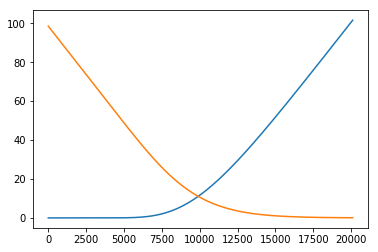

In [12]:
S_args = [(i / 100, 0.5, 100, 0.03, 0.4, 0.01) for i in range(1, 20100, 1)]
c_results = [c_lambda(*i) for i in S_args]
p_results = [p_lambda(*i) for i in S_args]
plt.plot(c_results)
plt.plot(p_results)

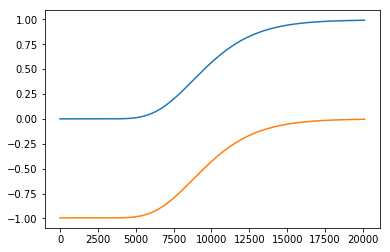

In [13]:
S_args = [(i / 100, 0.5, 100, 0.03, 0.4, 0.01) for i in range(1, 20100, 1)]
c_delta_results = [c_delta_lambda(*i) for i in S_args]
p_delta_results = [p_delta_lambda(*i) for i in S_args]
plt.plot(c_delta_results)
plt.plot(p_delta_results)

In [14]:
def fc_lambda(*args, **kwargs):
    global c_lambda
    return c_lambda(*args, **kwargs)

def fp_lambda(*args, **kwargs):
    global p_lambda
    return p_lambda(*args, **kwargs)

def fc_delta_lambda(*args, **kwargs):
    global c_delta_lambda
    return c_delta_lambda(*args, **kwargs)

def fp_delta_lambda(*args, **kwargs):
    global p_delta_lambda
    return p_delta_lambda(*args, **kwargs)

def fc_gamma_lambda(*args, **kwargs):
    global c_gamma_lambda
    return c_gamma_lambda(*args, **kwargs)

def fp_gamma_lambda(*args, **kwargs):
    global p_gamma_lambda
    return p_gamma_lambda(*args, **kwargs)

def fc_vega_lambda(*args, **kwargs):
    global c_vega_lambda
    return c_vega_lambda(*args, **kwargs)

def fp_vega_lambda(*args, **kwargs):
    global p_vega_lambda
    return p_vega_lambda(*args, **kwargs)

def fc_theta_lambda(*args, **kwargs):
    global c_theta_lambda
    return c_theta_lambda(*args, **kwargs)

def fp_theta_lambda(*args, **kwargs):
    global p_theta_lambda
    return p_theta_lambda(*args, **kwargs)

def fc_rho_lambda(*args, **kwargs):
    global c_rho_lambda
    return c_rho_lambda(*args, **kwargs)

def fp_rho_lambda(*args, **kwargs):
    global p_rho_lambda
    return p_rho_lambda(*args, **kwargs)

In [15]:
price = {
    "call": fc_lambda,
    "put": fp_lambda,
}

'''
greeks = {
    
    "call_delta": fc_delta_lambda,
    "put_delta": fp_delta_lambda,
    "call_gamma": fc_gamma_lambda,
    "put_gamma": fp_gamma_lambda,
    "call_vega": fc_vega_lambda,
    "put_vega": fp_vega_lambda,
    "call_theta": fc_theta_lambda,
    "put_theta": fp_theta_lambda,
    "call_rho": fc_rho_lambda,
    "put_rho": fp_rho_lambda,
}
'''

greeks = {
    "call": {
        "delta": fc_delta_lambda,
        "gamma": fc_gamma_lambda,
        "theta": fc_theta_lambda,
        "rho": fc_rho_lambda,
        "vega": fc_vega_lambda,
    },
    "put": {
        "delta": fp_delta_lambda,
        "gamma": fp_gamma_lambda,
        "theta": fp_theta_lambda,
        "rho": fp_rho_lambda,
        "vega": fp_vega_lambda,
    }
}

european_option = {"price": price, "greeks": greeks}

In [16]:
with open("european_option.lib", "wb") as fp:
    pkl.dump(european_option, fp)

In [17]:
del c, p, d1, d2, S, t, K, r, vol, q

American Option

binomial tree method  
In fact, the pricing process can be divided into tree generation and value calculation

In [18]:
from math import exp as m_exp
import numpy as np
from typing import Callable, Tuple
from numba import jit

In [19]:
def tree_generation(S: float, t: float, r: float, q: float, vol: float, n: int) -> Tuple[np.ndarray, float, float]:
    dt = t / n
    
    u = m_exp(vol * sqrt(dt))
    d = 1 / u
    p = (m_exp((r - q) * dt) - d) / (u - d)
    
    tree_ar = np.zeros((n + 1, n + 1))
    
    # boundary condition
    tree_ar[:, n] = S * u ** np.arange(n, -1, -1) * d ** np.arange(0, n + 1, 1)
    return tree_ar, p, dt, r, u, d

In [20]:
def valuation(f_middle: Callable[[np.ndarray, int, int], float], tree_array: np.ndarray, *args, **kwargs) -> Tuple[float, np.ndarray]:
    n1, n2 = tree_array.shape
    if n1 != n2: 
        raise ValueError("tree_array shape not acceptable")
    
    for i in range(n1 - 2, -1, -1):
        for j in range(0, i + 1):
            tree_array[j, i] = f_middle(tree_array, j, i, *args, **kwargs)
    return tree_array[0][0], tree_array

In [21]:
def value_end(tree_end_col: np.ndarray, K: float, option_type: {"put", "call"}, *args, **kwargs) -> np.ndarray:
    tp_cast = lambda x: 1 if x == "call" else -1
    tp_int = tp_cast(option_type)
    return np.where(tp_int * tree_end_col > tp_int * K, tp_int * (tree_end_col - K), np.zeros_like(tree_end_col)) 

In [22]:
def european_value_middle(tree_col: np.ndarray, x: int, y: int, r: float, dt: float, p: float) -> float:
    return m_exp(-r * dt) * (p * tree_col[x, y + 1] + (1 - p) * tree_col[x + 1, y + 1])

In [23]:
def american_value_middle(tree_col: np.ndarray, x: int, y: int, r: float, dt: float, p: float, option_type: {"put", "call"}, K: float, S0: float, u: float, d: float) -> float:
    tp_cast = lambda x: 1 if x == "call" else -1
    tp_int = tp_cast(option_type)
    return max(m_exp(-r * dt) * (p * tree_col[x, y + 1] + (1 - p) * tree_col[x + 1, y + 1]), max(tp_int * (S0 * u ** y * d ** x - K), 0))

In [24]:
tr, p, dt, r, u, d = tree_generation(50, 1, 0.03, 0.01, 0.4, 100)
tr[:, -1] = value_end(tr[:, -1], 50, "put")

In [25]:
_, mat = valuation(european_value_middle, tr.copy(), r=r, dt=dt, p=p)

In [26]:
_, mat2 = valuation(american_value_middle, tr.copy(), r=r, dt=dt, p=p, option_type="put", K=50.0, S0=50, u=u, d=d)

calculate greeks

In [27]:
def delta_on_tree(tree_ar: np.ndarray, S0: float, u: float, d: float) -> float:
    n1, n2 = tree_ar.shape
    if n1 < 2:
        raise ValueError("Tree too small to calculate delta")    
    return (tree_ar[0, 1] - tree_ar[1, 1]) / (S0 * (u - d))

In [28]:
def gamma_on_tree(tree_ar: np.ndarray, S0: float, u: float, d: float) -> float:
    n1, n2 = tree_ar.shape
    if n1 < 3:
        raise ValueError("Tree too small to calculate gamma")
    return (tree_ar[0, 2] + tree_ar[2, 2] - 2 * tree_ar[1, 2]) / (S0 * (u**2 - d**2))

In [29]:
def theta_on_tree(tree_ar: np.ndarray, dt: float) -> float:
    n1, n2 = tree_ar.shape
    if n1 < 3:
        raise ValueError("Tree too small to calculate theta")
    return (tree_ar[1, 1] - tree[0, 0]) / (2 * dt)

rho and vol must be calculated by two trees, so I will leave it to the class implementation

Pricing American Options using Monte Carlo method

In [30]:
from math import log

In [31]:
def generate_sample(S, r, q, vol, T, n, count):
    dt = T / n

    diff_mat = (np.random.randn(count, n) * vol * sqrt(dt) + (r - q - vol**2 / 2) * dt).astype("float64")
    diff_mat = np.hstack([np.ones([count, 1]) * log(S) , diff_mat])
    result_mat = np.exp(diff_mat.cumsum(axis=1))    
    return result_mat

In [39]:
sp = generate_sample(50, 0.03, 0.01, 0.3, 10, 100, 2000)

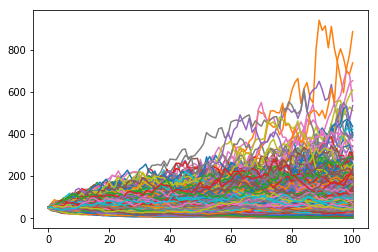

In [42]:
fig = plt.Figure()
_ = plt.plot(sp.T)

In [43]:
def asian_value(sim_mat: np.ndarray, K: float, option_type: {"call", "put"}) -> float:
    n1, n2 = sim_mat.shape
    type_cast = lambda x: 1 if x == "call" else -1
    type_int = type_cast(option_type)
    average = np.sum(sim_mat, axis=1) / n1
    return np.sum(np.where(average * type_int > K * type_int, type_int * (average - K), 0)) / n1

In [45]:
asian_value(sp, 2, "call")

0.9394943082775369

In [47]:
value = [asian_value(sp, i, "call") for i in range(1, 100)]

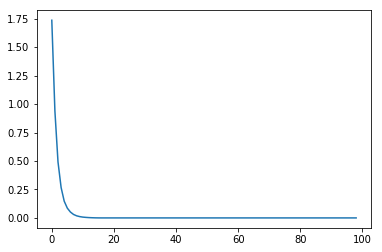

In [48]:
plt.plot(value)

In [49]:
l = {}

In [50]:
l[1]

KeyError: 1